<a href="https://colab.research.google.com/github/Roflz/stock-prediction/blob/main/predict_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# Installs/upgrades packages needed for running stock prediction program using Google Colab
# After installing/upgrading, Go to Runtime -> Restart runtime to apply changes

!pip install --upgrade pandas-datareader

     -------------------------------------- 109.5/109.5 kB 6.6 MB/s eta 0:00:00
     --------------------------------------- 10.5/10.5 MB 11.7 MB/s eta 0:00:00
     ---------------------------------------- 3.6/3.6 MB 28.6 MB/s eta 0:00:00
     --------------------------------------- 14.6/14.6 MB 46.7 MB/s eta 0:00:00


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

# parameters
ticker = "SPX"
years = 10

#set dates
end_date = date.today()
start_date = end_date - relativedelta(years=years)
print(f"Gathering data from {start_date} to {end_date}")

# function to help create the datasets
# for features (x), appends the last 50 prices
# for labels (y), appends the next price
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

# flattens a list of lists into 1 list
def flatten(l):
    return [item for sublist in l for item in sublist]

# Request data via Yahoo public API
df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
print(df)

# upload files and read csv (optional)
# df = files.upload()
# df = pd.read_csv(df)

# get number of trading days
df.shape

# set dimensions of dataset
df = df['Open'].values
df = df.reshape(-1, 1)

# split the data into training and testing sets
# training set is taking 1st 20% of data points (Oldest 20% of data points)
# test set is taking last 80% of data points (Most recent 80% of data points)
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])

# scale data between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

# create datasets using function
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

# initialize model as a sequential one with 96 units in the output’s dimensionality
# use return_sequences=True to make the LSTM layer with three-dimensional input and input_shape to shape our dataset
# Making the dropout fraction 0.2 drops 20% of the layers
# Finally add a dense layer with a value of 1 because we want to output one value
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# reshape data into 3d array for LSTM because it is sequential_3 which is expecting 3 dimensions, not 2
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# now compile the model
# used loss='mean_squared_error' because it is a regression problem
# use the adam optimizer to update network weights iteratively based on training data
model.compile(loss='mean_squared_error', optimizer='adam')

# Save model and start training!
# Every epoch refers to one cycle through the full training dataset
# batch size refers to the number of training examples utilized in one iteration
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_prediction.h5')

2022-08-04
2012-08-04
               High      Low     Open    Close    Volume  Adj Close
Date                                                               
2012-08-06  0.04901  0.04901  0.04901  0.04901       0.0    0.04901
2012-08-07  0.04952  0.04952  0.04952  0.04952  327600.0    0.04952
2012-08-08  0.04952  0.04952  0.04952  0.04952  259040.0    0.04952
2012-08-09  0.04952  0.04952  0.04952  0.04952       0.0    0.04952
2012-08-10  0.04901  0.04901  0.04901  0.04901   21323.0    0.04901
...             ...      ...      ...      ...       ...        ...
2018-01-24  0.05500  0.05500  0.05500  0.05500    7000.0    0.05500
2018-01-25  0.05500  0.05500  0.05500  0.05500    1160.0    0.05500
2018-01-26  0.05000  0.05000  0.05000  0.05000    1800.0    0.05000
2018-01-29  0.06000  0.05000  0.06000  0.05000   60817.0    0.05000
2018-01-30  0.05000  0.04500  0.05000  0.05000  150100.0    0.05000

[1380 rows x 6 columns]
Epoch 1/50
33/33 [==============================] - 5s 60ms/step - lo

8/8 [==============================] - 1s 15ms/step


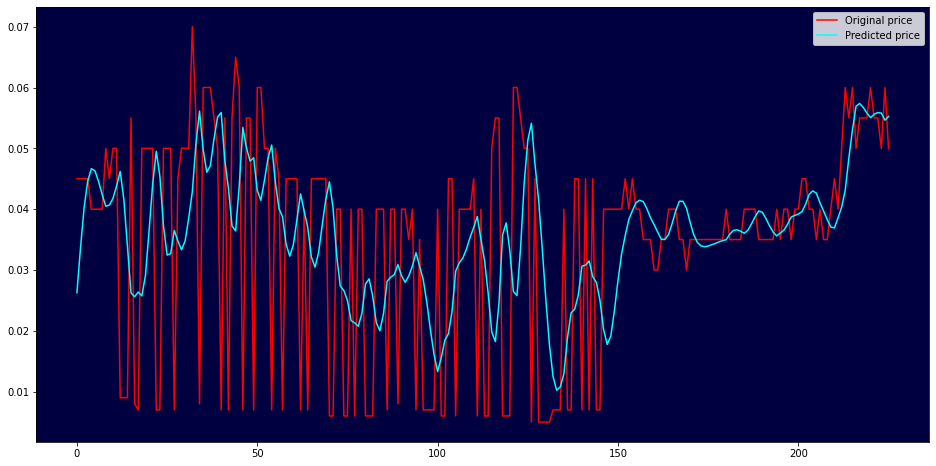

In [19]:
# load fitted model
model = load_model('stock_prediction.h5')

# visualize data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()

In [15]:
# Calculate Errors
import math

# flattens a list of lists into 1 list
def flatten(l):
    return [item for sublist in l for item in sublist]

def mean_absolute_error(actual, predicted):
  return abs(sum(flatten(actual)) - sum(flatten(predicted))) / predictions.size

def mean_squared_error(actual, predicted):
  return math.sqrt(abs(sum(flatten(y_test_scaled)) - sum(flatten(predictions)))**2 / predictions.size)

def mean_absolute_percentage_error(actual, predicted):
  error = sum(abs(actual - predicted) / abs(actual)) / predictions.size * 100
  return error[0]

# calculate Mean Absolute Error
MAE = mean_absolute_error(y_test_scaled, predictions)
print(f"Mean Absolute Error: {MAE}")

# calculate Mean Squared Error
MSE = mean_squared_error(y_test_scaled, predictions)
print(f"Mean Squared Error: {MSE}")

# calculate Mean Absolute Percentage Error
MAPE = mean_absolute_percentage_error(y_test_scaled, predictions)
print(f"Mean Absolute Percentage Error: {MAPE}")

# calculate Mean Absolute Scaled Error
# compares current model error with previous model error by a ratio (<1 means new model better, >1 means old model better)
# add this code when the time comes to make models more precise
# MASE = MAE_current / MAE_previous


Mean Absolute Error: 0.53137147131045
Mean Squared Error: 5.84508618441495
Mean Absolute Percentage Error: 2.5929223780594186


In [ ]:
# Calculate Prediction Intervals